# Volatility basket strategy

- This notebook presents a way to manually calculate volatility basket strategy
    - We construct a portfolio of weighted assets based on theme ("memecoins") and their rolling sharpe (exponential moving average)
    - We use DEX tokens from Ethereum
- This notebook offers you to build your basket on predefined CoinGecko categories
    - [See the category list here]()
- Note that for each category, we are only going to get a subset of tokens, because 
    - There is no cross chain trading
    - Some of the tokens are listed only on centralised exchanges

# Set up

Set up Trading Strategy data client.


In [108]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [109]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1

    # Coingecko categories to include
    #
    # See list here: TODO
    #
    chain_id = ChainId.ethereum
    categories = {"Meme"}
    
    # Alternative categories
    #categories = {"Artificial Intelligence (AI)"}
    #categories = {"Decentralized Finance (DeFi)"}
    
    #
    # Strategy parameters
    #
    min_asset_universe = 5  # How many assets we need in the asset universe to start running the index

    # At the start of the each month, we will pick 4 assets to
    picks_at_the_start_of_month = 4

    #
    # Inclusion criteria parameters:
    # - We set the length of various indicators used in the inclusion criteria
    # - We set minimum thresholds neede to be included in the index to filter out illiquid pairs
    #

    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("30d") // candle_time_bucket.to_timedelta()
    rebalance_volalitity_bars = pd.Timedelta("30d") // candle_time_bucket.to_timedelta()
    rolling_volume_bars = pd.Timedelta("30d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    min_volume = 1_000_000   # USD
    min_liquidity = 200_000  # USD
    
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2022, 8, 15)
    backtest_end = datetime.datetime(2024, 8, 15)


parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [110]:
import warnings

from tradeexecutor.utils.binance import create_binance_universe
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.client import Client
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions

from tradingstrategy.alternative_data.coingecko import CoingeckoUniverse, categorise_pairs
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradingstrategy.client import Client
from tradingstrategy.pair import HumanReadableTradingPairDescription
from tradeexecutor.strategy.execution_context import ExecutionMode, ExecutionContext, notebook_execution_context
from tradeexecutor.utils.binance import create_binance_universe
from tradeexecutor.strategy.universe_model import UniverseOptions



#: Assets used as the buy-and-hold benchmark values for our strategy,
#: but not traded by this strategy
BENCHMARK_PAIRS = [
    (ChainId.ethereum, "uniswap-v3", "WBTC", "USDT", 0.0005),
    (ChainId.ethereum, "uniswap-v3", "WETH", "USDC", 0.0005),
]


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id
    categories = Parameters.categories

    coingecko_universe = CoingeckoUniverse.load()
    print("Coingecko universe is", coingecko_universe)

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in BENCHMARK_PAIRS]

    # Assign categories to all pairs
    category_df = categorise_pairs(coingecko_universe, pairs_df)

    # Get all trading pairs that are memecoin, across all coingecko data
    mask = category_df["category"].isin(categories)
    category_pair_ids = category_df[mask]["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Deduplicate trading pairs - Choose the best pair with the best volume
    pairs_df = deduplicate_pairs_by_volume(pairs_df)

    print(
        f"Total {len(pairs_df)} pairs to trade on {chain_id.name} for categories {categories}",        
    )

    print("Top pair matches (including benchmark pairs):")
    for _, pair in pairs_df.head(10).iterrows():
        print(f"   Pair: {pair.base_token_symbol} - {pair.quote_token_symbol} ({pair.exchange_slug})")

    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=False,  # TODO: Currently web API has problems with liquidity for some pairs
        liquidity_time_bucket=TimeBucket.d1,  # Daily liquidity
    )

    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset="0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48",  # USDC
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark tokens so they can be separated from the rest of the tokens
    # for the index construction
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = True

    return strategy_universe

# Suppress Pandas warnings within the context manager
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    strategy_universe = create_trading_universe(
        None,
        client,
        notebook_execution_context,
        UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
    )


Coingecko universe is <CoingeckoUniverse for 1000 tokens>


load_partial_data() method is designed to load data for low number or trading pairs, got 50 - this might be slow


Total 50 pairs to trade on ethereum for categories {'Meme'}
Top pair matches (including benchmark pairs):
   Pair: WETH - USDC (uniswap-v3)
   Pair: PEPE - WETH (uniswap-v3)
   Pair: TURBO - WETH (uniswap-v3)
   Pair: Neiro - WETH (uniswap-v3)
   Pair: MEME - WETH (uniswap-v3)
   Pair: SHIB - WETH (uniswap-v3)
   Pair: NEIRO - WETH (uniswap-v3)
   Pair: PEIPEI - WETH (uniswap-v3)
   Pair: SPX - WETH (uniswap-v2)
   Pair: DOGE - WETH (uniswap-v3)


### Asset to trading pair map

- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [111]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Category trading pairs 48
Benchmark trading pairs 2


# Indicators

- Precalculate indicators used by the strategy

In [112]:
import pandas as pd
import numpy as np
import pandas_ta

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount


def trailing_sharpe(
    close: pd.Series, 
    window_length_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=window_length_bars).mean()    
    vol = returns.rolling(window=window_length_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


def trailing_sharpe_business_month(close, window_length_bars, pair: TradingPairIdentifier, dependency_resolver) -> pd.Series:
    """Snap the trailing returns to business month start day/hour."""

    hour = 8  # 8AM

    def first_day_8am(group):
        target_time = group.index[0].floor('D') + pd.Timedelta(hours=hour)
        return group.loc[target_time] if target_time in group.index else np.NaN
        #return group.loc.get(target_time)

    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"window_length_bars": window_length_bars},
    )    

    # TODO: Clean up here?
    # Let's clear this up
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    ewm = trailing_sharpe.ewm(span=ann_factor/4).mean()  # Quaterly
    try:
        first_day_series = ewm.resample('MS').apply(first_day_8am)
    except IndexError as e:
        #  IndexError: index 0 is out of bounds for axis 0 with size 0
        print(f"trailing_sharpe_business_month(): Skipping {pair.get_ticker()} because of {e}")
        return pd.Series(dtype=float, index=pd.DatetimeIndex([]))

    # first_day_series.attrs["time_bucket"] = TimeBucket.d30  # Hint this is monthly data
    return first_day_series


def top_pairs_business_month(
    strategy_universe: TradingStrategyUniverse, 
    picks_at_the_start_of_month: int,
    dependency_resolver: IndicatorDependencyResolver,    
) -> pd.Series:
    """Get the pairs that have the best trailing sharpe at the start of the month.
    
    - These are the pairs we will trade

    """





def available_pairs(
    close: pd.Series, 
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Get the available tradeable pairs on each date.

    - Pairs for which have business month trailing sharpe available
    
    - Because the trading universe is only expanding, this number is only going up

    :return:
        Series with pair count for each timestamp    
    """    
    
    series = dependency_resolver.get_indicator_data_pairs_combined("trailing_sharpe_business_month")
    df = series.to_frame(name='value')
    # Convert index: timestamp, (pair_id, value) tuples
    df = df.reset_index(level='pair_id')

    # Remove our benchmark tokens to pollute this number
    df = df[~df["pair_id"].isin(benchmark_pair_ids)]

    # This code groups by the date part of the DatetimeIndex and counts the number of assets for each day.
    return df.groupby(df.index)["pair_id"].nunique()


def volatility(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=window_length_bars).std()
    return rolling_std


def rolling_cumulative_volume(volume: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=window_length_bars).sum()
    return rolling_volume


def rolling_liquidity_avg(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=window_length_bars).mean()
    return  rolling_liquidity_close

    
def volume_inclusion_criteria(   
    close: pd.Series, 
    min_volume: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
    pair: TradingPairIdentifier,    
) -> pd.Series:
    """Calculate pair inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    - For each month we pick the N pairs that have the best mohtly trailing sharpe 

    TODO: Add liquidity check later

    :return:
        Series that is True or False whether the pair meets inclusion criteria at any point of time
    """
    series = dependency_resolver.get_indicator_data(
        "rolling_cumulative_volume",
        pair=pair
    )
    mask = series >= min_volume

    # Need to match the DatetimeIndex of trailing_sharpe_business_month
    # for boolean array max() is the same sany()
    monthly_data = mask.resample('MS').max()
    # Because we sample each month month start, the pair is not availabe until the next month
    return monthly_data.shift(-1).fillna(0).astype(int)


def included_pairs(
    close: pd.Series, 
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Included pairs is a combination of available pairs and inclusion criteria.

    - At a given moment of time, which of all available pairs are truly tradeable

    - Pairs for which have business month trailing sharpe available
    
    - Pairs that meet the inclusion criteria

    :return:
        Series with pair count for each timestamp
    """    
    
    series = dependency_resolver.get_indicator_data_pairs_combined("volume_inclusion_criteria")

    # Drop all False values (pair was not included)
    series = series.loc[series == True]

    df = series.to_frame(name='value')
    # Convert index: timestamp, (pair_id, value) tuples
    df = df.reset_index(level='pair_id')

    # Remove our benchmark tokens to pollute this number
    df = df[~df["pair_id"].isin(benchmark_pair_ids)]

    # This code groups by the date part of the DatetimeIndex and counts the number of assets for each day.
    return df.groupby(df.index)["pair_id"].nunique()
    

def monthly_traded_pairs(   
    strategy_universe: TradingStrategyUniverse, 
    picks_at_the_start_of_month: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """For each month, get the list of the pairs we will trade.
    
    - This series can be exploded and forward filled to get hourly boolean mask
    
    :return:
       Monthly Pandas series with (pair_id, timestamp) index that contains sharpe values only for top picks of that month.

       The value of the series is monthly trailing sharpe for the pair.
    """

    # Get trailing sharepe for all pairs as (pair_id, timestamp) indexed series
    df = pd.DataFrame({
        "trailing_sharpe_business_month": dependency_resolver.get_indicator_data_pairs_combined("trailing_sharpe_business_month"),
        "volume_inclusion_criteria": dependency_resolver.get_indicator_data_pairs_combined("volume_inclusion_criteria"),
    })

    # TODO: Drop assets with a sharpe ratio threshold?
    
    # Drop pairs that do not meet volume inclusion criteria, and leave the sharpes left 
    # for the pairs that do meet the criteria
    df["filtered_sharpe"] = df["trailing_sharpe_business_month"].loc[df["volume_inclusion_criteria"] == True]

    top_picks = df["filtered_sharpe"].groupby('timestamp').nlargest(picks_at_the_start_of_month)
    
    # MultiIndex is now (timestamp, pair_id, timestamp) -> fix it
    top_picks = top_picks.droplevel(0)

    """
    pair_id  timestamp 
    36926    2022-08-01          NaN
    37316    2022-08-01          NaN
    52587    2022-08-01          NaN
    68900    2022-08-01          NaN
    36926    2022-09-01          NaN
    37316    2022-09-01          NaN
    52587    2022-09-01          NaN
    68900    2022-09-01          NaN
    2701164  2022-10-01     2.788998
    2711945  2022-10-01    -0.039353
    """
    
    return top_picks
    

def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    """Create indicator descriptions.
    
    - Indicators are automatically recalculated and cached by the backtest runner,
      if indicator Python function body or parameters change
    """
    indicator_set = IndicatorSet()
    indicator_set.add(
        "trailing_sharpe",
        trailing_sharpe,
        {"window_length_bars": parameters.trailing_sharpe_bars},
        IndicatorSource.close_price,
    )
    indicator_set.add(
        "volatility",
        volatility,
        {"window_length_bars": parameters.rebalance_volalitity_bars},
        IndicatorSource.close_price,
    )
    indicator_set.add(
        "rolling_cumulative_volume",
        rolling_cumulative_volume,
        {"window_length_bars": parameters.rolling_volume_bars},
        IndicatorSource.ohlcv,
    )    
    # TODO: Currently web API issues loading this data for certain pairs
    #
    # indicator_set.add(
    #     "rolling_liquidity_avg",
    #     rolling_liquidity_avg,
    #     {"window_length_bars": parameters.rolling_liquidity_bars,
    #     IndicatorSource.liquidity,
    # )        
    indicator_set.add(
        "trailing_sharpe_business_month",
        trailing_sharpe_business_month,
        {"window_length_bars": parameters.trailing_sharpe_bars},
        IndicatorSource.close_price,
        order=2,  # After trailing_sharpe
    )    
    indicator_set.add(
        "available_pairs",
        available_pairs,  
        {},  
        IndicatorSource.strategy_universe,
        order=3,  # After trailing_sharpe_business_month
    )       
    indicator_set.add(
        "volume_inclusion_criteria",
        volume_inclusion_criteria,  
        {"min_volume": parameters.min_volume},  
        IndicatorSource.ohlcv,
        order=3,  
    )       

    
    indicator_set.add(
        "included_pairs",
        included_pairs,  
        {},
        IndicatorSource.strategy_universe,
        order=4,  
    )       

    indicator_set.add(
        "monthly_traded_pairs",
        monthly_traded_pairs,  
        {
            "picks_at_the_start_of_month": parameters.picks_at_the_start_of_month,
        },  
        IndicatorSource.strategy_universe,
        order=5,  
    )       

    return indicator_set


indicators = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=create_indicators,
    parameters=parameters,
    max_workers=1,
)

Reading cached indicators trailing_sharpe, volatility, rolling_cumulative_volume, trailing_sharpe_business_mon…

Using indicator cache /Users/moo/.cache/indicators/ethereum_1h_50_2022-08-15-2024-08-15_ff


# Examine indicator data

- Manually inspect that our indicator data calcuations looks correct
- Display Sharpe et. al for example asset

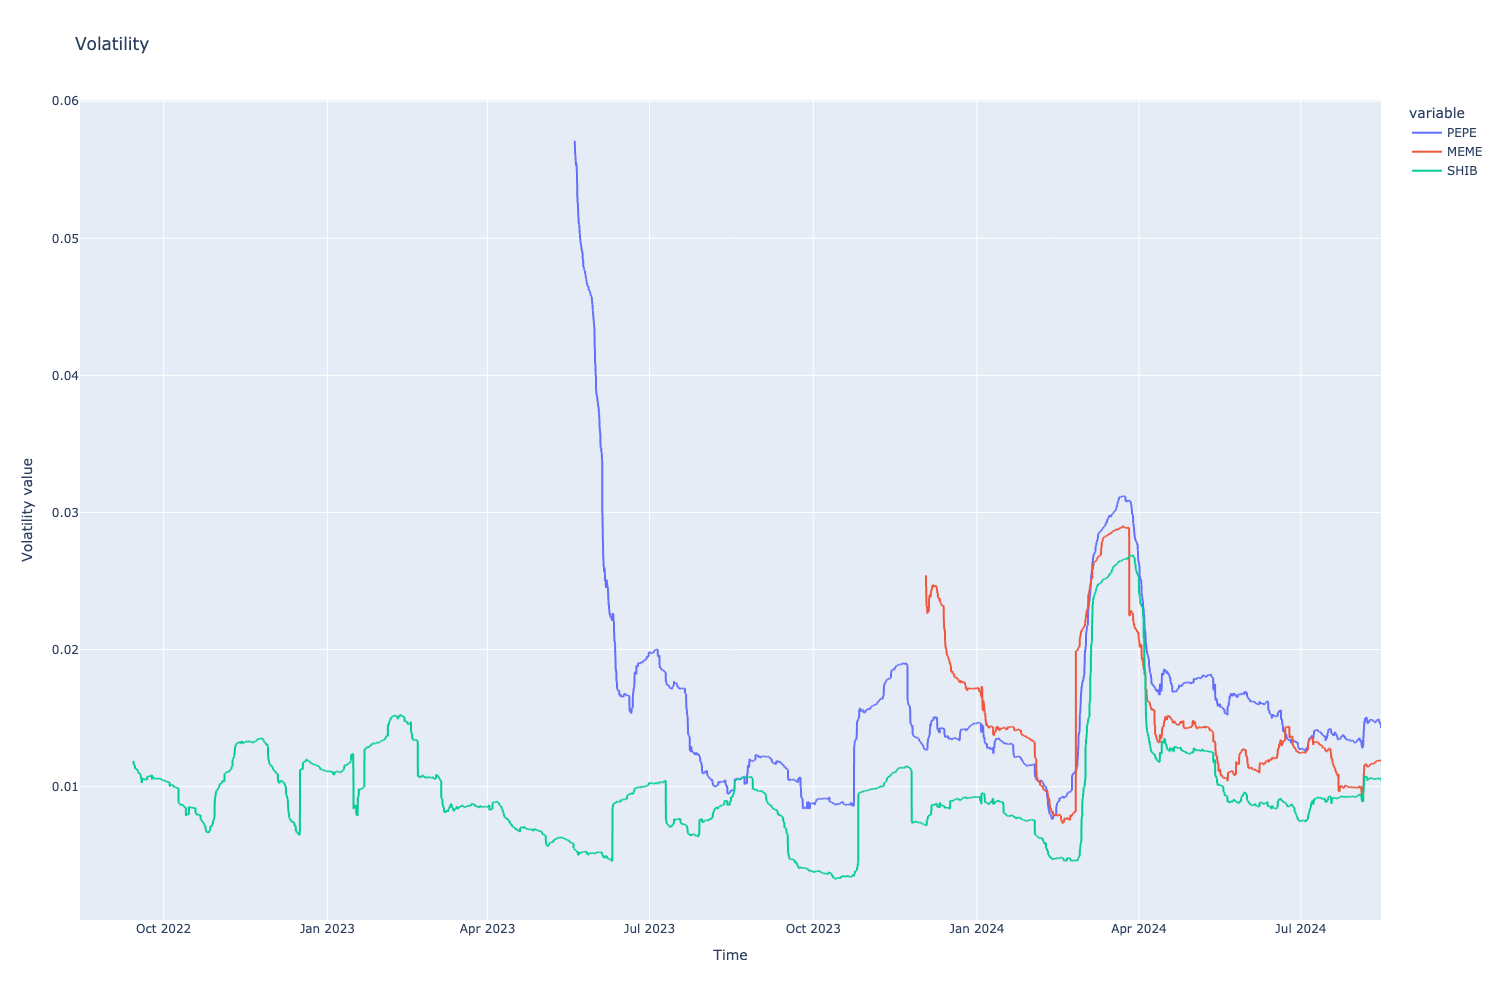

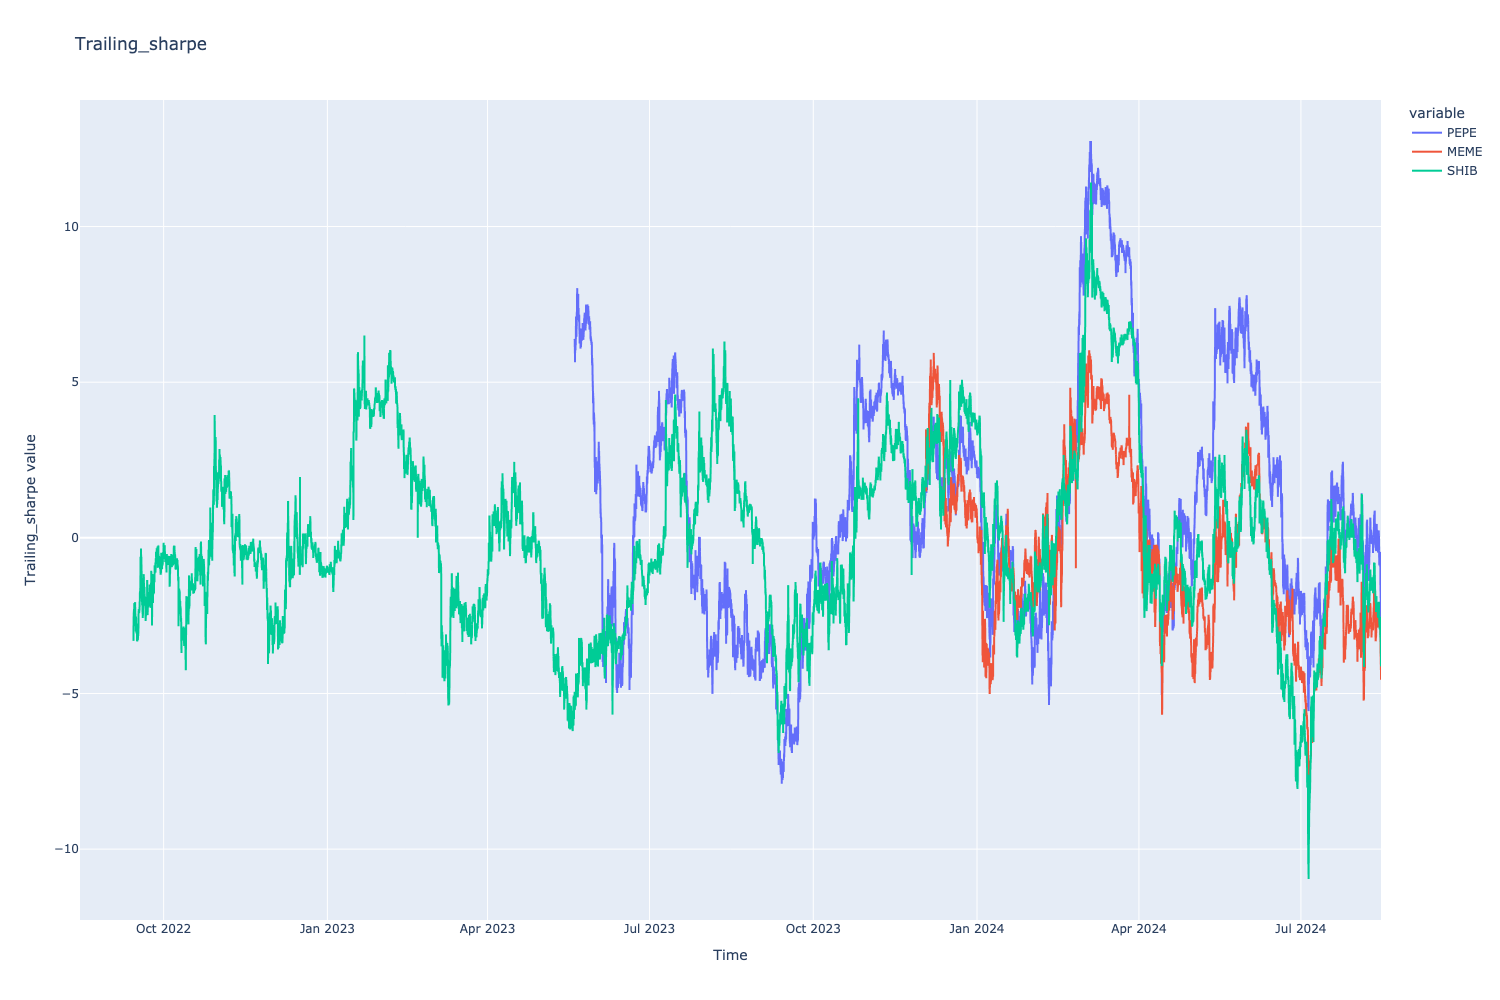

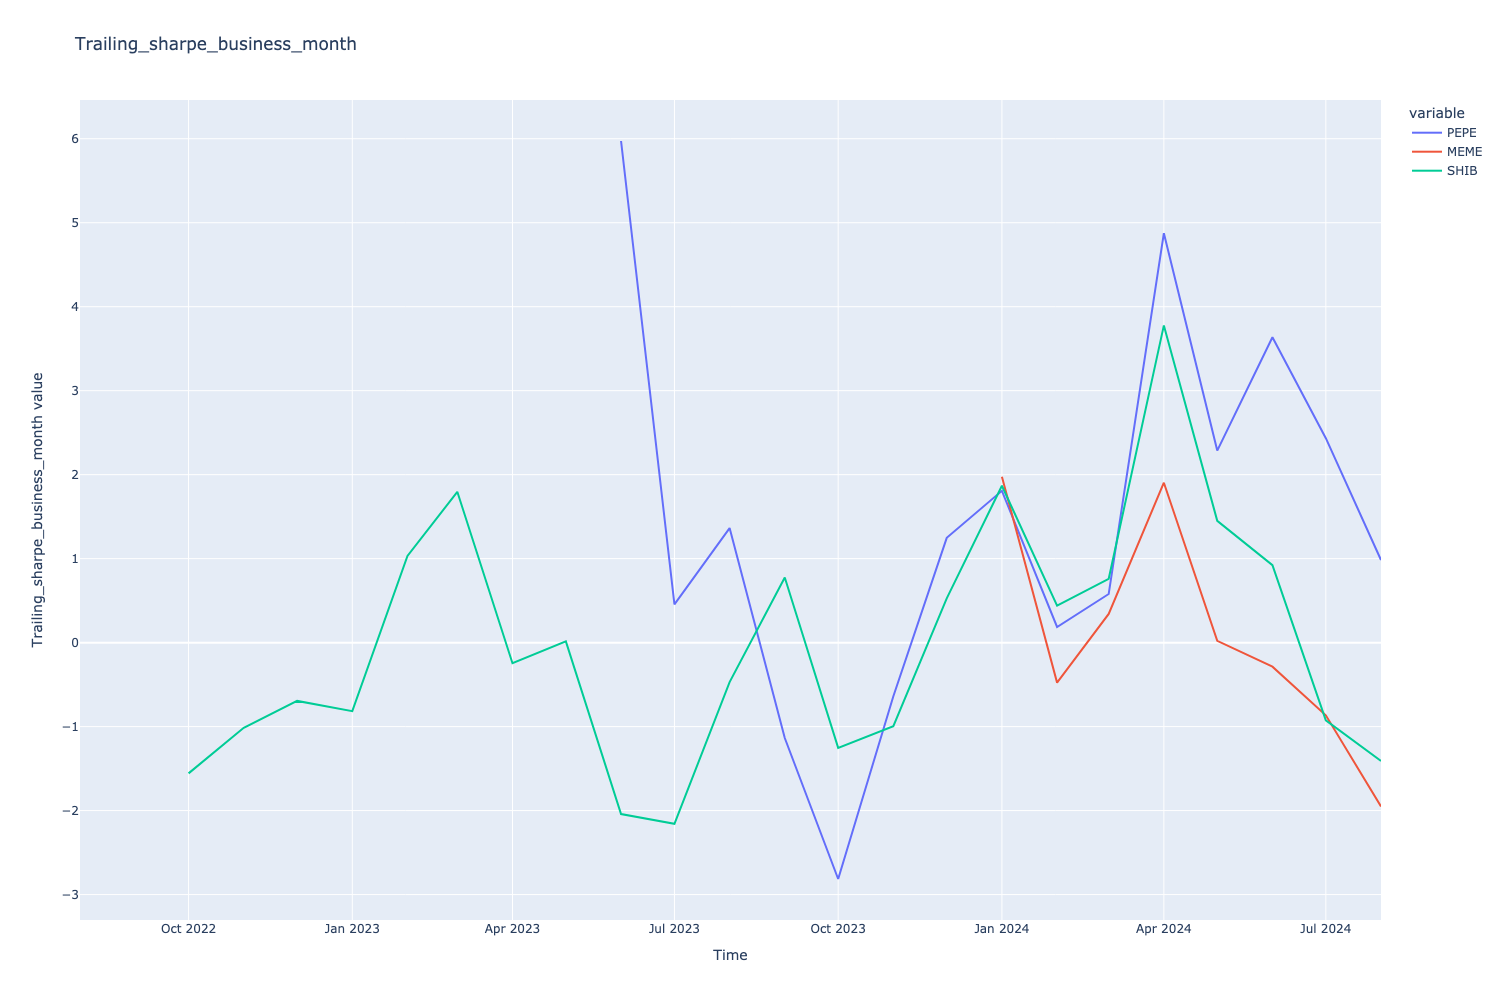

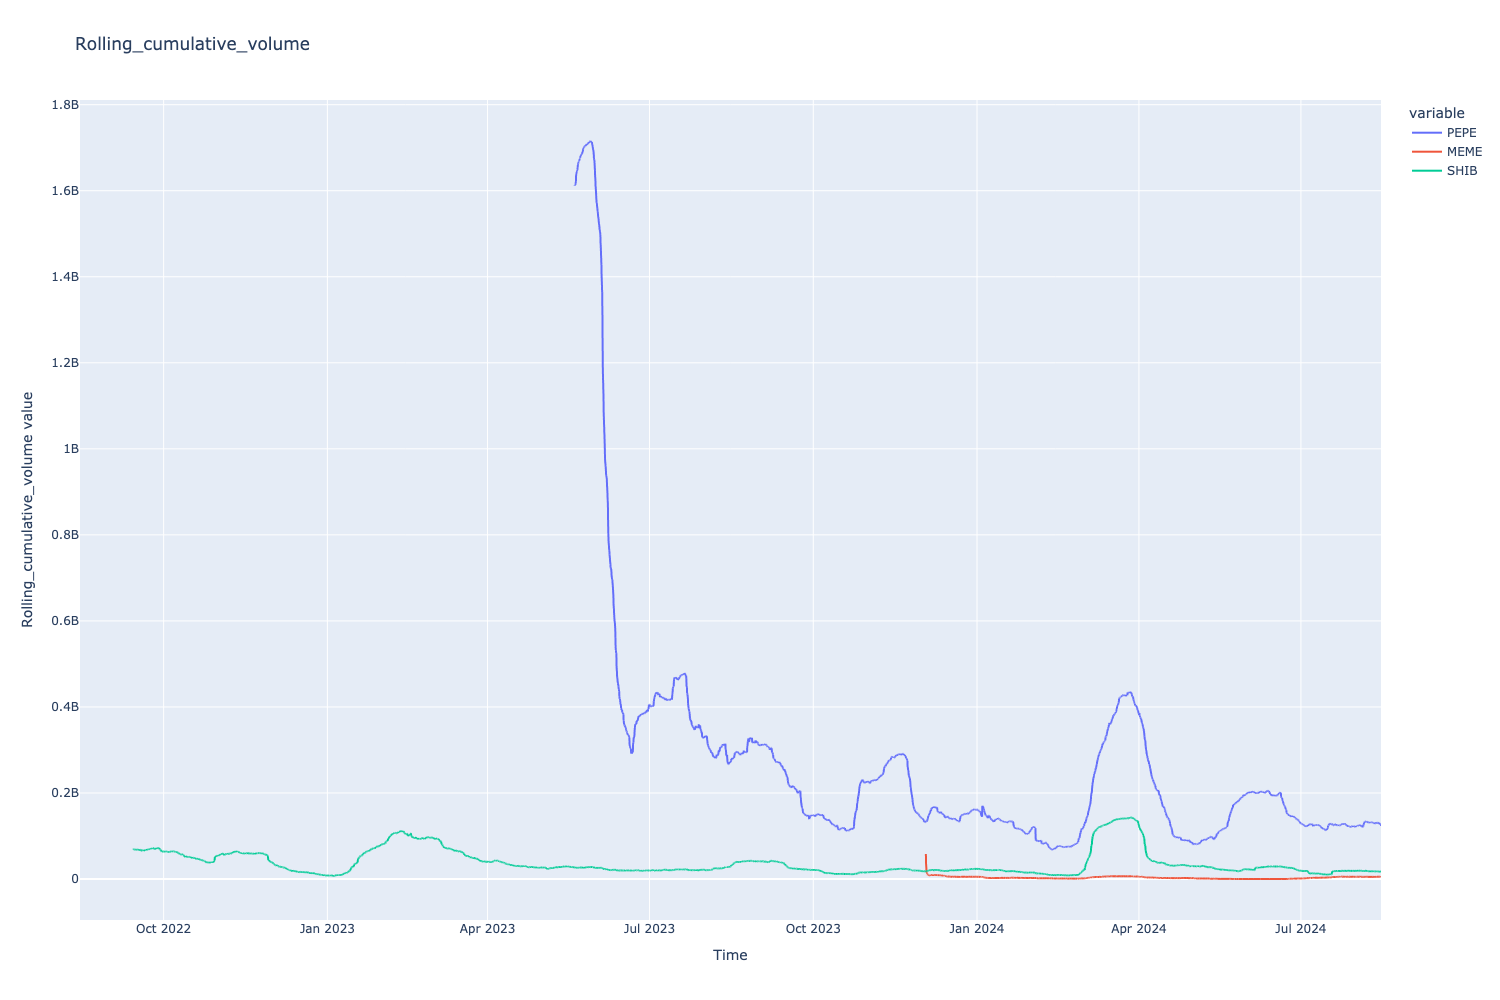

In [113]:
import plotly.express as px

selected_assets = ["PEPE", "MEME", "SHIB"]

checked_indicators = [
    "volatility", 
    "trailing_sharpe", 
    "trailing_sharpe_business_month", 
    "rolling_cumulative_volume", 
    # "rolling_liquidity_avg"
]

for indicator_name in checked_indicators:

    data = {}
    for symbol in selected_assets:
        pair = token_map[symbol]
        data[symbol] = series = indicators.get_indicator_series(indicator_name, pair=pair)

        if series is None or len(series) == 0:
            print(f"Asset {symbol} has no data for {indicator_name}")

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"{indicator_name.capitalize()} value")
    fig.update_xaxes(title="Time")
    fig.show()

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [114]:
series = indicators.get_indicator_series("available_pairs")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = exceeds_threshold[exceeds_threshold].first_valid_index()
backtest_end = series.index[-1]

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2022-08-01 00:00:00 - 2024-08-01 00:00:00


# Calculate example asset returns

- Calculate daily returns for the whole trading universe

In [115]:
from tradeexecutor.analysis.returns import calculate_returns

returns_series = calculate_returns(strategy_universe)

Show returns of a single trading pair.

timestamp
2023-04-19 22:00:00         NaN
2023-04-19 23:00:00    0.021819
2023-04-20 00:00:00   -0.001576
2023-04-20 01:00:00    0.191325
2023-04-20 02:00:00    0.002846
Name: close, dtype: float64

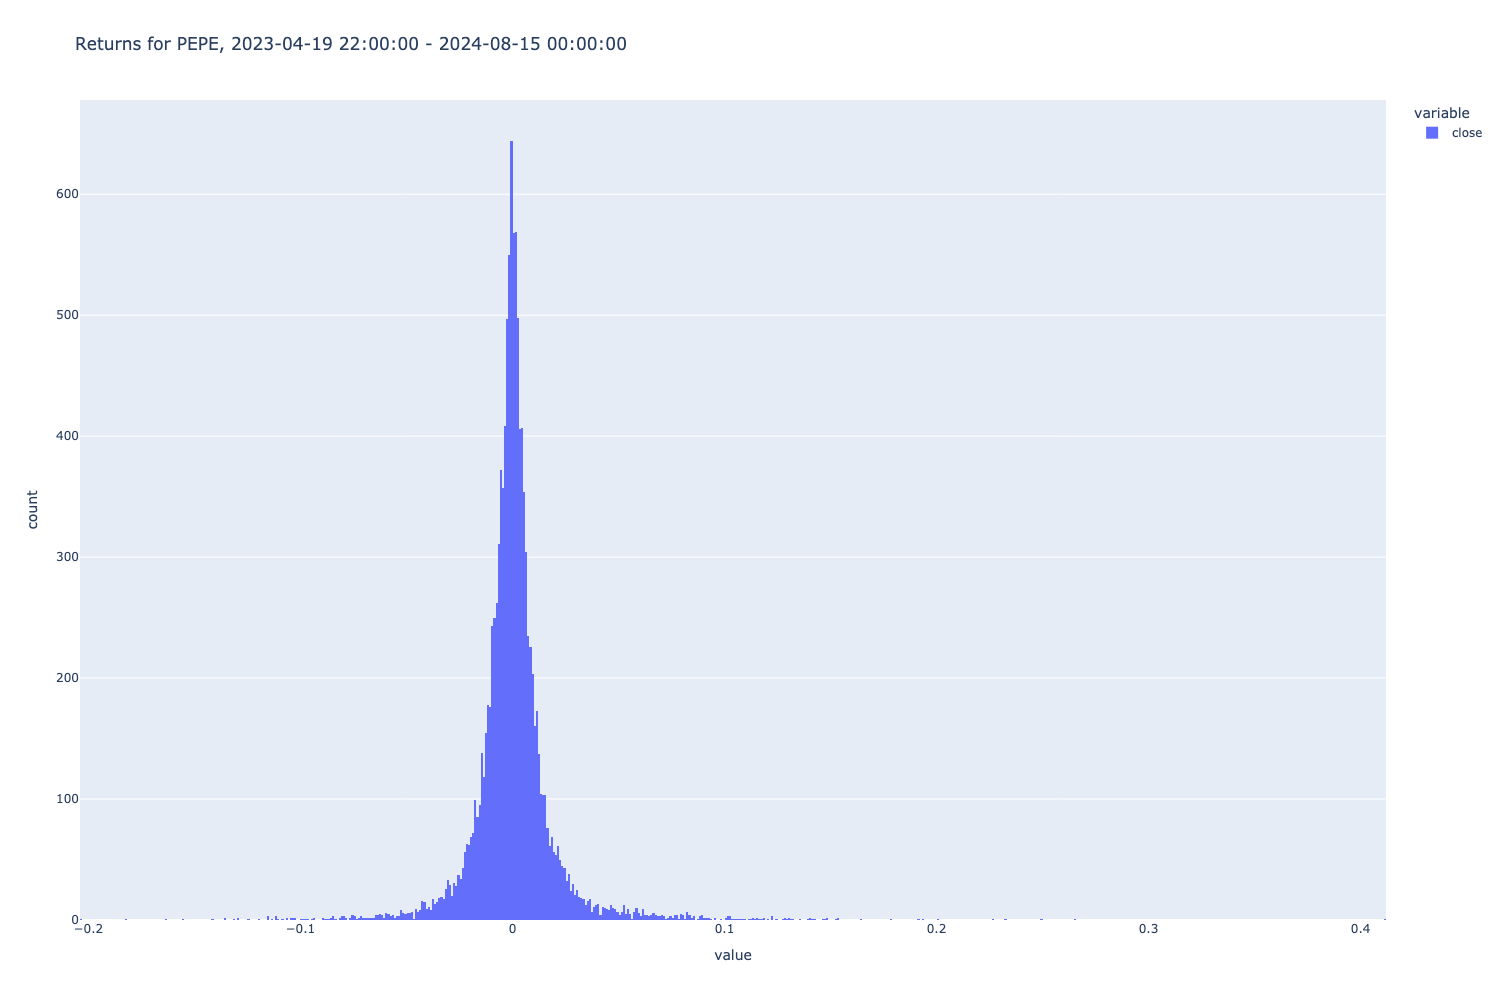

In [116]:
import plotly.express as px


pair = token_map["PEPE"]
pair_returns = returns_series.loc[pair.internal_id]
start = pair_returns.index[0]
end = pair_returns.index[-1]

display(pair_returns.head(5))

fig = px.histogram(
    pair_returns,
    title=f"Returns for {pair.base.token_symbol}, {start} - {end}",
)
display(fig)

# Calculate inclusion criteria

- Even if a trading pair has OHCLV data ready it might not mean the pair is tradeable
    - Coingecko data includes tokens in practice illiquid and untradeable
    - The pair does not have liquidity or volume
- We create a mask that tells when a pair reached volume and liquidity threshold and becomes tradeable, so it can be later included in the index
- If we do not have inclusion criteria, then we can abhorrent jumps in returns when the strategy attempst to buy illiquid token



In [117]:
# Create Pandas Series with index(pair_id, timestamp) with value True/False if the pair is eligiable at the given moment

rolling_cumulative_volume_df = indicators.get_indicator_data_pairs_combined("rolling_cumulative_volume")

volume_criteria = rolling_cumulative_volume_df > Parameters.min_volume

inclusion_df = pd.DataFrame({
    "volume_criteria": volume_criteria,
    "rolling_cumulative_volume_df": rolling_cumulative_volume_df,
})

# liquidity criteria disabled for now
# inclusion_df["included"] = inclusion_df["volume_criteria"] & inclusion_df["liquidity_criteria"]
inclusion_df["included"] = inclusion_df["volume_criteria"]

/Users/moo/code/trade-executor/tradeexecutor/strategy/pandas_trader/strategy_input.py:752: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



Diagnose our inclusition criteria by showing when a certain popular pair was included, and how the data changes around the inclusion timepoint.

In [118]:
pair = token_map["PEPE"]

included_at = inclusion_df["included"].xs(pair.internal_id, level='pair_id')[lambda x: x == True].index[0]

print(f"Pair {pair} (#{pair.internal_id}) was included at {included_at}")
# Display some rows around the inclusion date
before = included_at - pd.Timedelta(hours=4)
after = included_at + pd.Timedelta(hours=4)

mask = (
    (inclusion_df.index.get_level_values('pair_id') == pair.internal_id) & 
    (inclusion_df.index.get_level_values('timestamp') >= before) &
    (inclusion_df.index.get_level_values('timestamp') <= after)
)

snippet = inclusion_df[mask]
display(snippet)


Pair <Pair PEPE-WETH spot_market_hold at 0x11950d141ecb863f01007add7d1a342041227b58 (0.3000% fee) on exchange uniswap-v3> (#3018988) was included at 2023-05-19 21:00:00


volume_criteria  rolling_cumulative_volume_df  \
pair_id timestamp                                                            
3018988 2023-05-19 17:00:00            False                           NaN   
        2023-05-19 18:00:00            False                           NaN   
        2023-05-19 19:00:00            False                           NaN   
        2023-05-19 20:00:00            False                           NaN   
        2023-05-19 21:00:00             True                  1.612607e+09   
        2023-05-19 22:00:00             True                  1.612858e+09   
        2023-05-19 23:00:00             True                  1.612085e+09   
        2023-05-20 00:00:00             True                  1.612288e+09   
        2023-05-20 01:00:00             True                  1.613028e+09   

                             included  
pair_id timestamp                      
3018988 2023-05-19 17:00:00     False  
        2023-05-19 18:00:00     False  
        2023-05-19 19:00:00     False  
        2023-05-19 20:00:00     False  
        2023-05-19 21:00:00      True  
        2023-05-19 22:00:00      True  
        2023-05-19 23:00:00      True  
        2023-05-20 00:00:00      True  
        2023-05-20 01:00:00      True

# Available assets

- Check how the asset universe developers 
- Because of limited number of assets, we might not do any kind of basket early on in the history
- Because of inclusion criteria, filtering away low liquid assets, we might want to trade less assets than available 

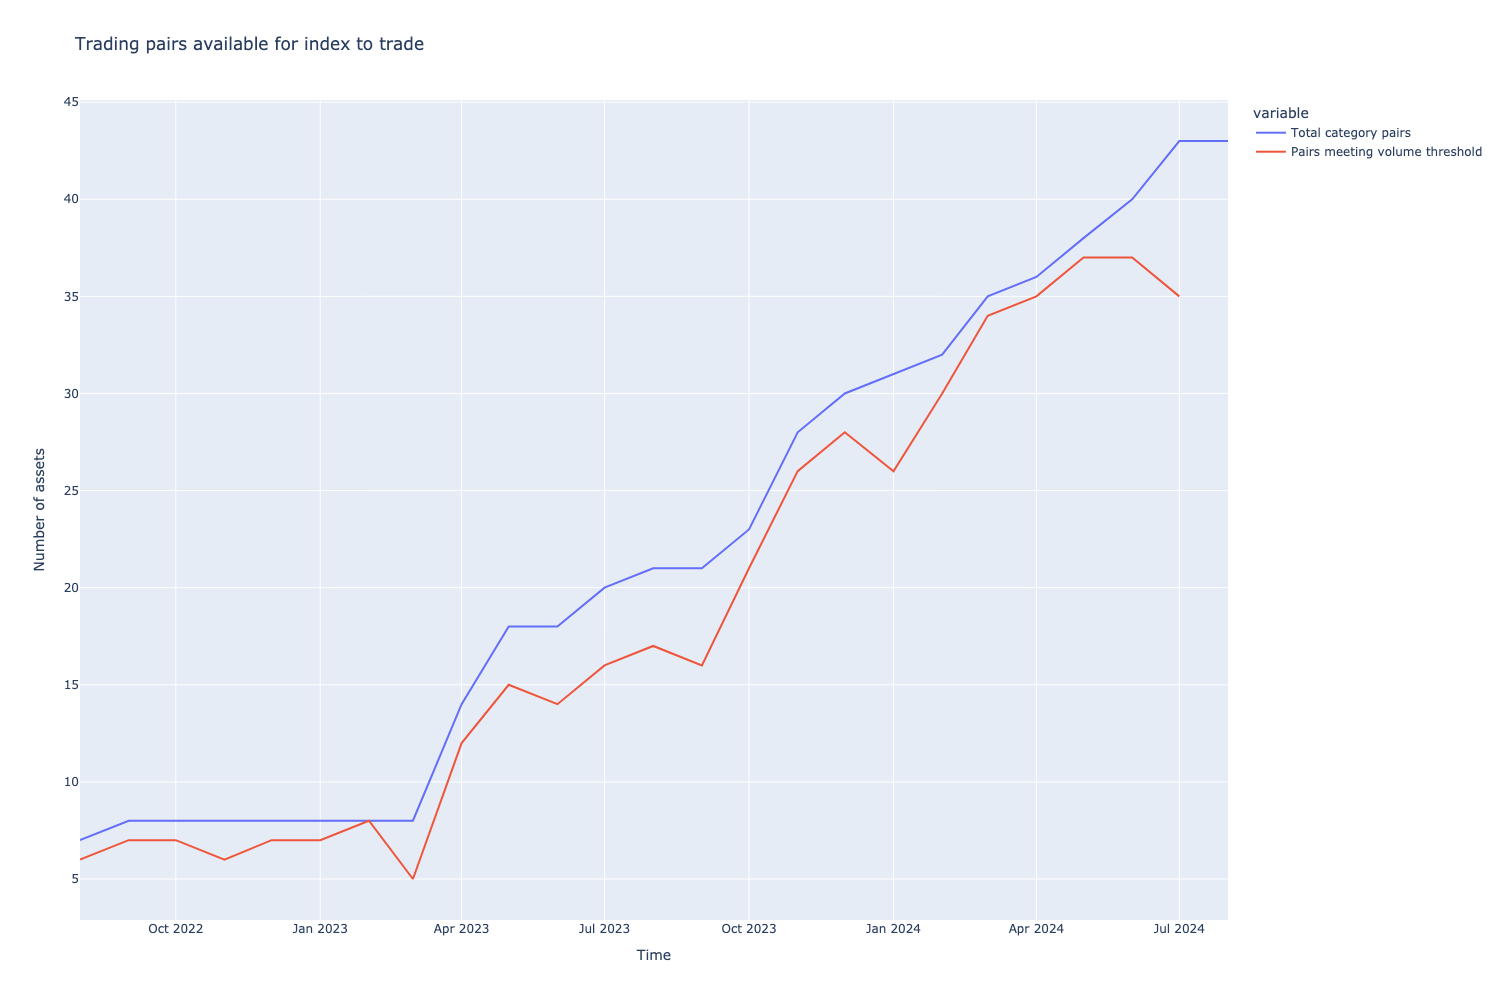

Total category pairs  Pairs meeting volume threshold
timestamp                                                       
2022-08-01                     7                             6.0
2022-09-01                     8                             7.0
2022-10-01                     8                             7.0
2022-11-01                     8                             6.0
2022-12-01                     8                             7.0

In [119]:
import plotly.express as px

df = pd.DataFrame({
    "Total category pairs": indicators.get_indicator_series("available_pairs"),
    "Pairs meeting volume threshold": indicators.get_indicator_series("included_pairs")
})

fig = px.line(df, title='Trading pairs available for index to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

display(df.head(5))

# Calculate basket weights 

- Calculate asset weighting for the portfolio construction
- Weight in the normalised value of `volatility` indicator for all pairs currently active 
- The result is a `pd.Series` with MultiIndex (pair_id, timestamp)

## All-inclusive diagnostics example

- First plot out of a portfolio with all pairs, without any kind of filtering

In [120]:
filter_pairs_in_category = lambda pair: pair.internal_id in category_pair_ids

# Get indicator series combined across all pairs with MultiIndex(pair_id, timestamp)
series = indicators.get_indicator_data_pairs_combined("volatility", pair_filter=filter_pairs_in_category)

total_value_per_timestamp = series.groupby(level='timestamp').sum()
normalised_weight_series = series.div(series.index.get_level_values('timestamp').map(total_value_per_timestamp))

# Check calcualted weights at a given timestamp
values_at_timestamp = normalised_weight_series.xs(pd.Timestamp('2024-08-14'), level='timestamp')
display(values_at_timestamp.head(6))

/Users/moo/code/trade-executor/tradeexecutor/strategy/pandas_trader/strategy_input.py:752: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



pair_id
3018988    0.017013
3047249    0.023716
3842242         NaN
3376429    0.013805
2697640    0.012276
3823566         NaN
dtype: float64

Display asset weight evolution over time - all assets

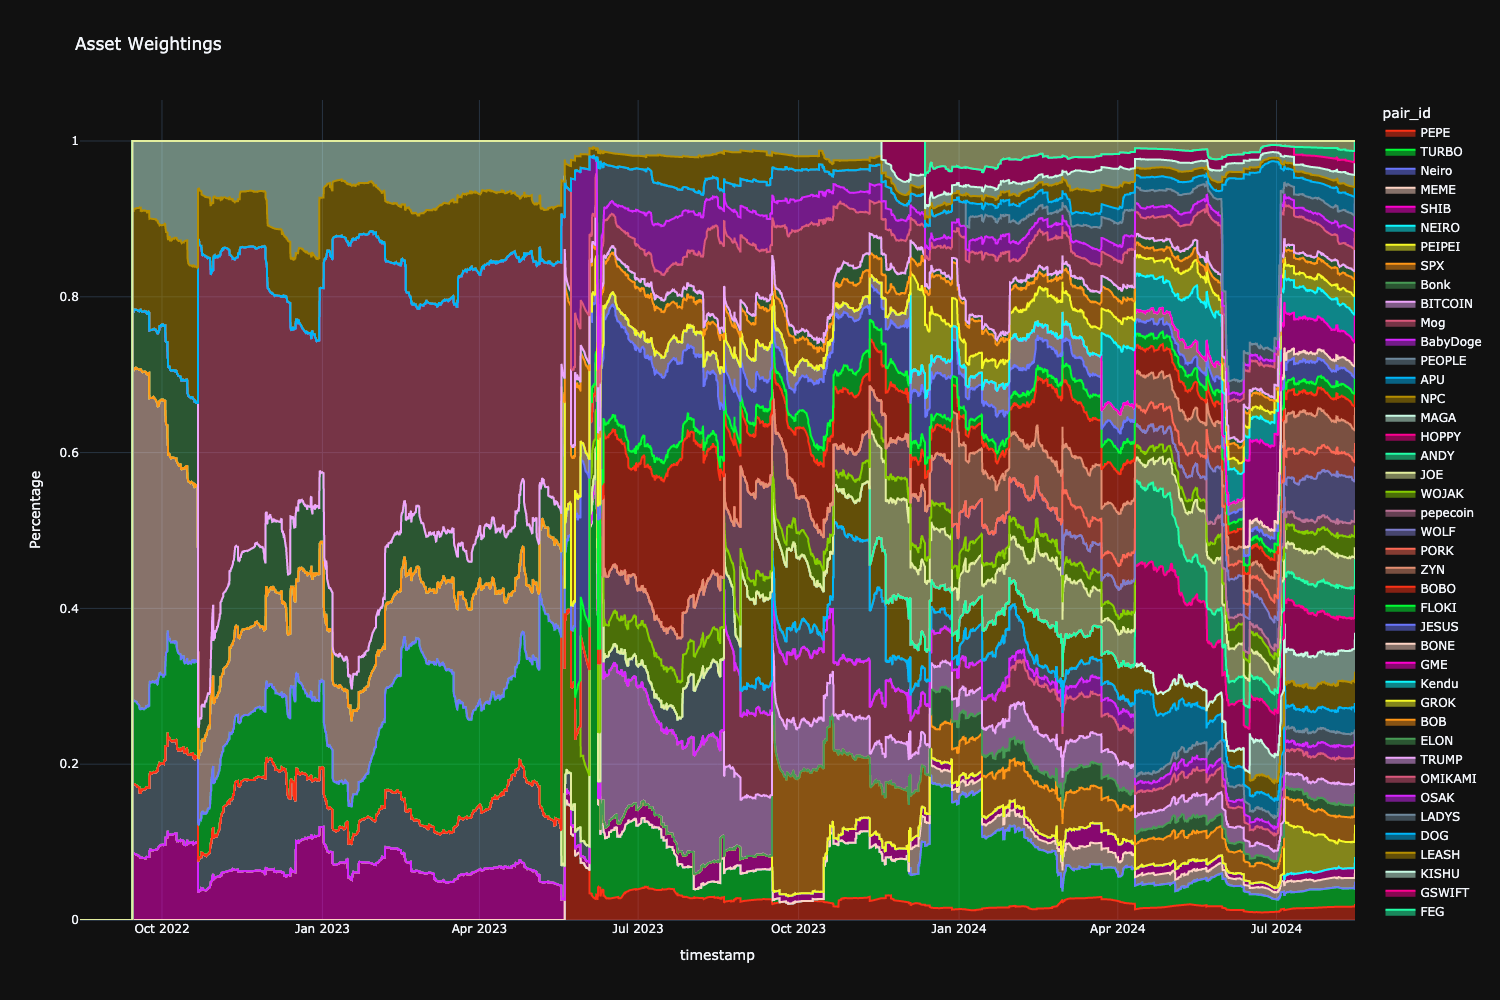

In [121]:
import plotly.express as px
import plotly.colors as colors

color_palette = colors.qualitative.Light24

# Add labels instead of raw pair ids.
# Convert (pair_id, timestamp) series to DataFrame where each pair is its own column
human_normalised_weights_df = normalised_weight_series.unstack(level="pair_id")

human_normalised_weights_df = human_normalised_weights_df.rename(columns=lambda pair_id: strategy_universe.data_universe.pairs.get_pair_by_id(pair_id).base_token_symbol)

fig = px.area(
    human_normalised_weights_df, 
    title='Asset Weightings',
    labels={'index': 'Time', 'value': 'Percentage'},
    template='plotly_dark',
    color_discrete_sequence=color_palette,
)

fig.show()

## Narrow down with our basket selection criteria

- We have more assets than we want to trade, so we narrow down the basket to the top assets of each period
- We also apply the inclusion criteria here, as we do not want to trade illiquid assets

In [122]:
# Get indicator series combined across all pairs with MultiIndex(pair_id, timestamp)
# with our 
series = indicators.get_indicator_data_pairs_combined("volatility", pair_filter=filter_pairs_in_category)

#print("We are trading pairs: ", series.index.get_level_values('pair_id').unique())
print(f"Our volality data is {len(series)} rows")

# Get our top picks for each month
monthly_traded_pairs = indicators.get_indicator_series("monthly_traded_pairs")

# display(monthly_traded_pairs.head(25))

def filter_included(index_tuple):
    # TODO: Slowish 
    pair_id, timestamp = index_tuple
    rounded_ts = timestamp.to_period("M").to_timestamp()
    sharpe = monthly_traded_pairs.get((pair_id, rounded_ts))
    return pd.notna(sharpe)

# Zero out pairs for the timetamps when they do not meet the inclusion criteria
masked_tradeable = series.index.map(filter_included)
traded_series = series[masked_tradeable]

total_value_per_timestamp = traded_series.groupby(level='timestamp').sum()
normalised_weight_series = traded_series.div(traded_series.index.get_level_values('timestamp').map(total_value_per_timestamp))

# display(normalised_weight_series)

# Check calcualted weights at a given timestamp.
# We should get 100% weighted picks_at_the_start_of_month number of pairs
# Timestamp is randomly picked, may change - TODO add logic to pick in the middle of a run
check_date = pd.Timestamp('2023-06-01')
values_at_timestamp = normalised_weight_series.xs(check_date, level='timestamp')

print(f"Normalised weights at {check_date}")
display(values_at_timestamp)

/Users/moo/code/trade-executor/tradeexecutor/strategy/pandas_trader/strategy_input.py:752: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



Our volality data is 371727 rows
Normalised weights at 2023-06-01 00:00:00


pair_id
3018988    0.122660
3031971    0.338577
3018875    0.206648
3026347    0.332115
dtype: float64

## Narrowed down asset selection

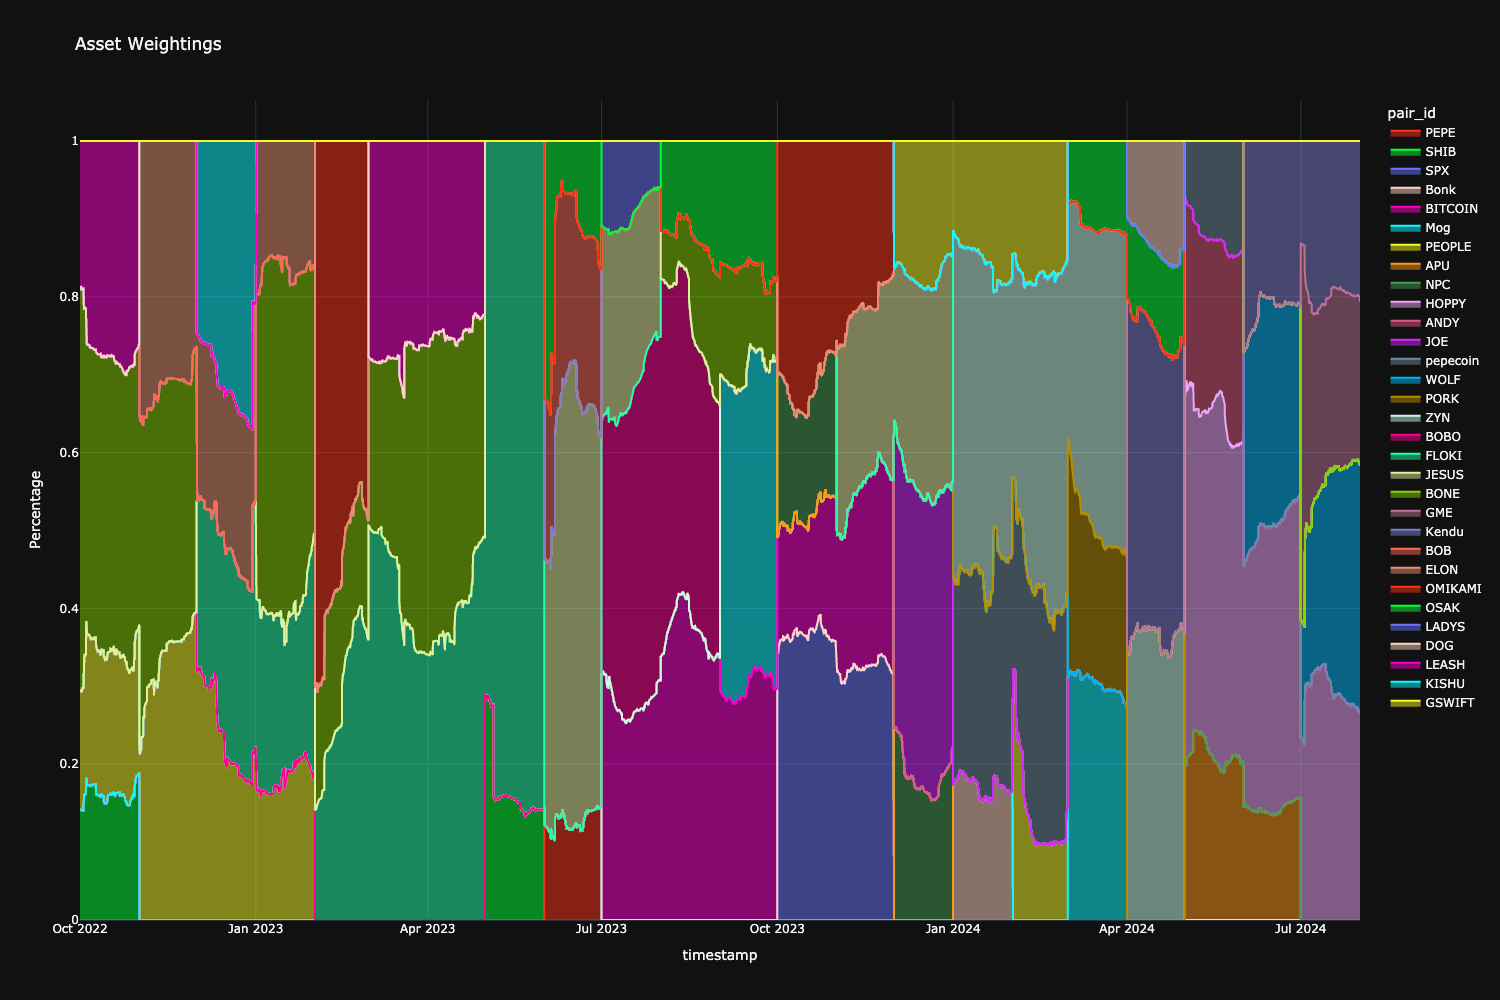

In [127]:
# Add labels instead of raw pair ids.
# Convert (pair_id, timestamp) series to DataFrame where each pair is its own column
human_normalised_weights_df = normalised_weight_series.unstack(level="pair_id")

human_normalised_weights_df = human_normalised_weights_df.rename(columns=lambda pair_id: strategy_universe.data_universe.pairs.get_pair_by_id(pair_id).base_token_symbol)

fig = px.area(
    human_normalised_weights_df, 
    title='Asset Weightings',
    labels={'index': 'Time', 'value': 'Percentage'},
    template='plotly_dark',
    color_discrete_sequence=color_palette,
)

fig.show()

# Strategy simulation

- Calculate index returns
- Assumes zero fees, zero price impact



In [123]:
# Put series for calculations into a single DataFrame,
# and along the same (pair_id, timestamp) index

df = pd.DataFrame({
    "normalised_weight": normalised_weight_series,    
    "returns": returns_series,
})

display(df.tail(5))


normalised_weight   returns
pair_id timestamp                                       
3825573 2024-08-14 20:00:00                NaN  0.003902
        2024-08-14 21:00:00                NaN -0.000251
        2024-08-14 22:00:00                NaN -0.003998
        2024-08-14 23:00:00                NaN  0.005159
        2024-08-15 00:00:00                NaN -0.008958

Calculate index returns.

In [124]:
# Calculate returns for each pair for each hour
df['weighted_returns'] = df['returns'].fillna(0) * df['normalised_weight'].fillna(0)

# At this point, we drop pair_id and just have timestamp index
index_returns = df['weighted_returns'].groupby('timestamp').sum()

# Turn index_returns series to equity curve
initial_index_value = 1

index_equity = initial_index_value * (1 + index_returns).cumprod()

index_df = pd.DataFrame({
    "returns": index_returns,
    "equity": index_equity,
})

display(index_df)

returns        equity
timestamp                                 
2022-08-15 00:00:00      0.0      1.000000
2022-08-15 01:00:00      0.0      1.000000
2022-08-15 02:00:00      0.0      1.000000
2022-08-15 03:00:00      0.0      1.000000
2022-08-15 04:00:00      0.0      1.000000
...                      ...           ...
2024-08-14 20:00:00      0.0  15729.809506
2024-08-14 21:00:00      0.0  15729.809506
2024-08-14 22:00:00      0.0  15729.809506
2024-08-14 23:00:00      0.0  15729.809506
2024-08-15 00:00:00      0.0  15729.809506

[17545 rows x 2 columns]

Do simplified tearsheet for the index returns.

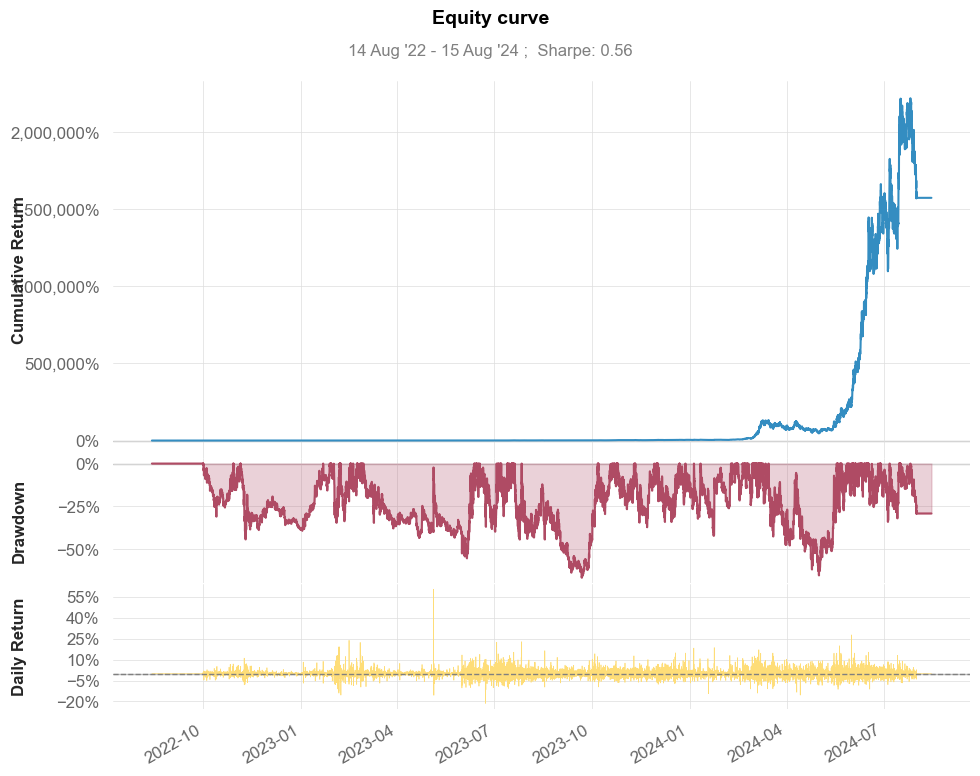

In [125]:
from tradeexecutor.visual.equity_curve import visualise_equity_curve

fig = visualise_equity_curve(index_df["returns"])
display(fig)

# Benchmark data

- Benchmark against tokens in the tradeable set, but also tokens outside the set (BTC)

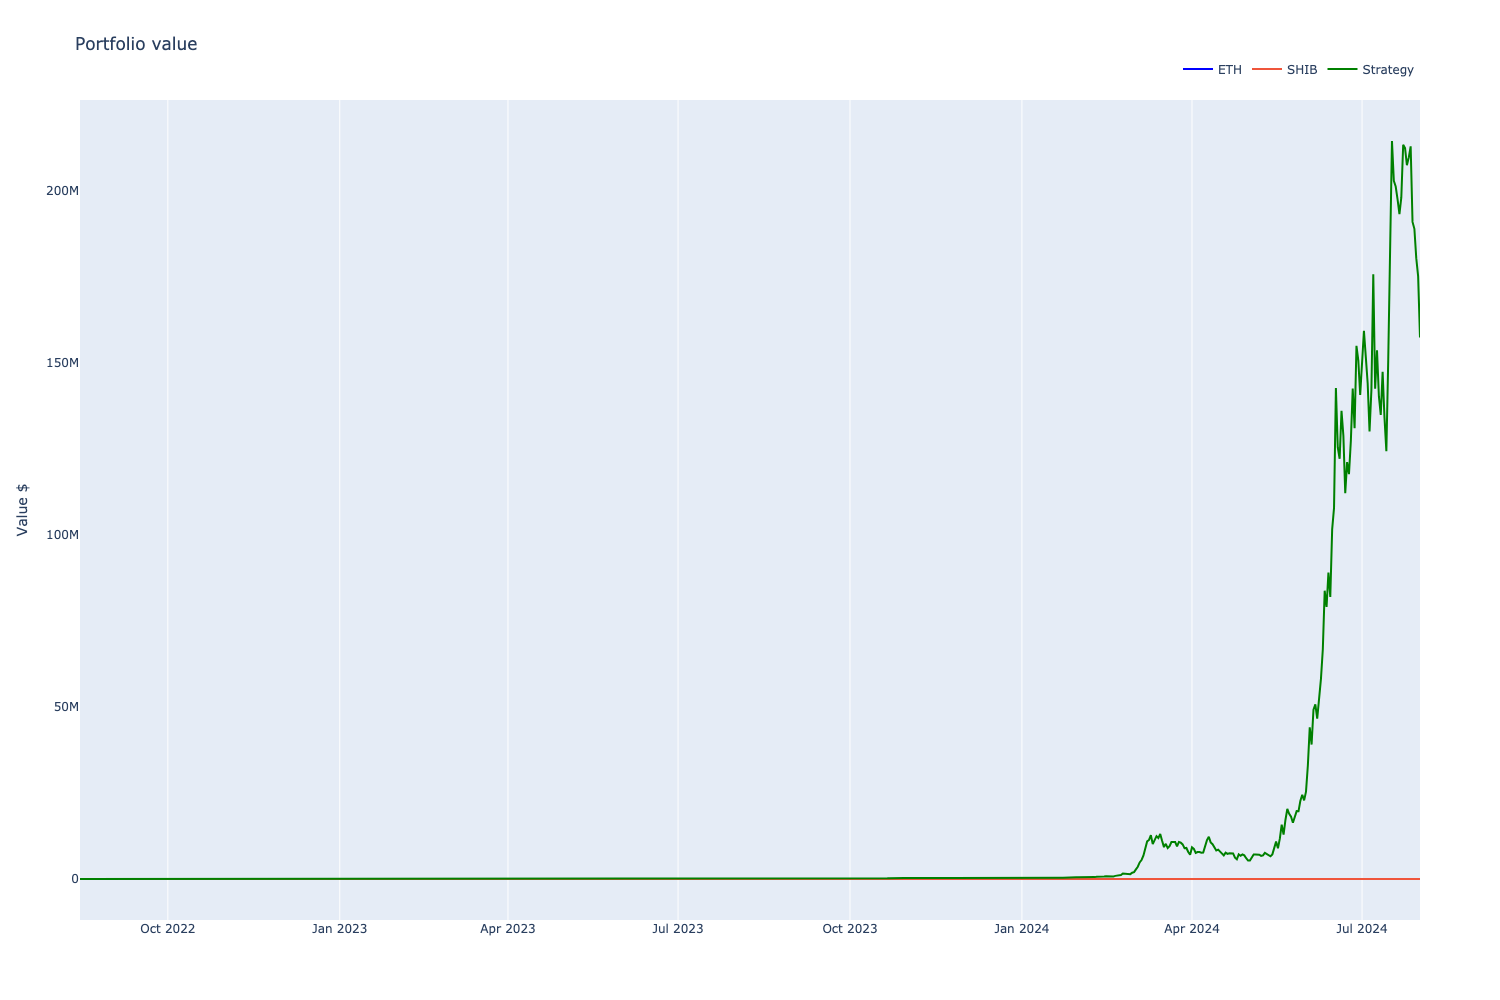

In [128]:
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

from tradeexecutor.analysis.curve import DEFAULT_BENCHMARK_COLOURS, CurveType

initial_cash = 10_000

# Some asset we check in our index
example_assets = ["BTC", "WETH", "SHIB"]  

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=initial_cash,
    max_count=4,
    start_at=backtest_start,
    interesting_assets=example_assets,
)

# Add our strategy in the index to visualisation mix in
benchmark_indexes["Strategy"] = index_df["equity"] * initial_cash
benchmark_indexes["Strategy"].attrs = {
    "name": "Strategy",
    'returns_series_type': 'cumulative_returns', 
    'curve': CurveType.equity,
    "colour": DEFAULT_BENCHMARK_COLOURS["Strategy"],
}

fig = visualise_equity_curve_benchmark(
    state=None,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=False,
    start_at=backtest_start,
    end_at=backtest_end,
)

fig.show()